# Comparison across sequencing technologies 
March 10th 2022

## Overview 
* We have sequencing data from 10x 5', 10x 3' and Smart-seq2 for Glioblastoma cell lines
* We will start by comparing the number of detected genes, number of counts, etc.
* Finally, we'll compare gene expression using pseudo-bulk counts 

In [1]:
import scanpy as sc 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
from scipy.stats import pearsonr

# sc.set_figure_params(dpi=100)
sc.settings.verbosity = 1
sc.logging.print_header()

/home/laura.vicente/miniconda3/envs/ipykernel_py3/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/laura.vicente/miniconda3/envs/ipykernel_py3/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/laura.vicente/miniconda3/envs/ipyk

scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.23.5 scipy==1.10.1 pandas==2.0.2 scikit-learn==1.2.2 statsmodels==0.14.0 python-igraph==0.10.4 pynndescent==0.5.10


In [2]:
# File location 
# 10x 3' From Multiome experiments
gex3 = sc.read_h5ad('./mcherry_alignment/multiome/data/3GEX_processed_cnv.h5ad')

# Smart-seq2 
ss2 = sc.read_h5ad('./SS2/data/SS2_pca.h5ad')

# 10X 5' 
gex5 = sc.read_h5ad('./mcherry_alignment/5GEX/data/5GEX_run2_processed.h5ad')

In [4]:
gex5.obs['sample_type'] = 'GL261-GSCs'
gex5.obs.loc[gex5.obs['sample'].isin(['C10', 'C7', 'C8', 'C9']),'sample_type'] = 'GL261'

In [6]:
ss2.obs['sample_type'] = 'GL261-GSCs'
ss2.obs.loc[ss2.obs['sample'].isin(['C11', 'C12', 'C13']),'sample_type'] = 'GL261'

In [7]:
# Let's consider only samples related to cultured cells
gex3 = gex3[gex3.obs['sample'].isin(['C2','S2','S4','S3','C3'])].copy()

In [8]:
gex3.obs['sample_type'] = 'GL261-GSCs'
gex3.obs.loc[gex3.obs['sample'].isin(['C2', 'C3']),'sample_type'] = 'GL261'

In [9]:
gex3.obs['sample_type'].value_counts()

sample_type
GL261-GSCs    7269
GL261         4293
Name: count, dtype: int64

In [10]:
set(ss2.obs['sample'])

{'C11', 'C12', 'C13', 'S10', 'S11', 'S12', 'S9'}

In [11]:
ss2.obs['sample_type'].value_counts()

sample_type
GL261         1329
GL261-GSCs    1102
Name: count, dtype: int64

In [12]:
gex5.obs['sample_type'].value_counts()

sample_type
GL261-GSCs    20062
GL261          9310
Name: count, dtype: int64

In [16]:
def compareQC(adata_list=[], data_id=[], var1='total_counts',var2='n_genes_by_counts', var3='sample', var4='sample_type'):
    all_metrics = pd.DataFrame({'total_counts':[], 'total_genes':[],'technology':[], 'sample':[], 'sample_type':[], 'tech':[]})
    
    for s in range(len(adata_list)):
        adata = adata_list[s]
        all_metrics = pd.concat([all_metrics, pd.DataFrame({'total_counts':adata.obs[var1], 
                      'total_genes':adata.obs[var2],
                      'sample':adata.obs[var3],
                                                            'sample_type':adata.obs[var4],
                      'tech':data_id[s]})], join = 'inner')
        
    return all_metrics


# Returns an Average transcriptome matrix for all cell types (groups) in the adata object 
def avgMatrix(adata =[] , groups = 'Leiden_annotation'):
    res = pd.DataFrame(columns=adata.var_names, index=adata.obs[groups].cat.categories)                                                                                                 

    for clust in adata.obs[groups].cat.categories: 
        res.loc[clust] = adata[adata.obs[groups].isin([clust]),:].X.mean(0)
    
    return res 

In [11]:
metrics_df = compareQC([gex3,gex5,ss2], data_id=['gex3','gex5','ss2'])

In [12]:
metrics_gex3 = compareQC([gex3], data_id=['gex3'])
metrics_gex5 = compareQC([gex5], data_id=['gex5'])
metrics_ss2 = compareQC([ss2], data_id=['ss2'])

print(metrics_gex3['total_counts'].mean())
print(metrics_gex5['total_counts'].mean())
print(metrics_ss2['total_counts'].mean())

print(metrics_gex3['total_genes'].mean())
print(metrics_gex5['total_genes'].mean())
print(metrics_ss2['total_genes'].mean())

2434.376
10865.539
3117016.2
1431.0303580695381
3656.2208565981205
8329.305224187578


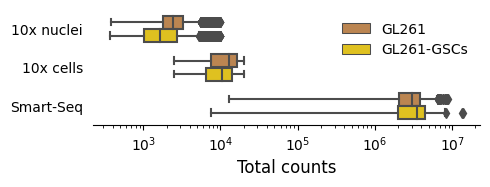

In [13]:
with rc_context({'font.size': 10.0,'figure.figsize': (5,1.5)}):

#     flierprops = dict(marker='o', markersize=5, markeredgecolor='black', markerfacecolor='black', alpha=0.5)
    
    g = sns.boxplot(y="tech", x="total_counts", hue="sample_type", data=metrics_df,
                    width=0.7, linewidth=1.5, palette=('peru','gold'),
                   dodge=True)

    g.set_xscale("log")
    g.spines['top'].set_visible(False)
    g.spines['right'].set_visible(False)
    g.spines['left'].set_visible(False)
    g.set_xlabel('Total counts', fontsize=12)
    g.set_ylabel('')
    g.yaxis.set_ticklabels(['10x nuclei','10x cells','Smart-Seq'])
    g.tick_params(left=False)
    g.legend(frameon=False)
    plt.savefig(f'./figures/counts.png', bbox_inches='tight', dpi=300)


In [14]:
with rc_context({'font.size': 10.0,'figure.figsize': (5,1.5)}):

#     flierprops = dict(marker='o', markersize=5, markeredgecolor='black', markerfacecolor='black', alpha=0.5)
    
    g = sns.boxplot(y="tech", x="total_genes", hue="sample_type", data=metrics_df,
                    width=0.7, linewidth=1.5, palette=('peru','gold'),
                   dodge=True)

    g.set_xscale("log")
    g.spines['top'].set_visible(False)
    g.spines['right'].set_visible(False)
    g.spines['left'].set_visible(False)
    g.set_xlabel('Total genes', fontsize=12)
    g.set_ylabel('')
    g.yaxis.set_ticklabels(['10x nuclei','10x cells','Smart-Seq'])
    g.tick_params(left=False)
    g.legend([],[], frameon=False)
    plt.savefig(f'./figures/genes.png', bbox_inches='tight', dpi=300)

In [15]:
plt.figure(figsize=(12, 3))
g = sns.boxplot(x="sample", y="total_counts",
            hue="tech", 
            data=metrics_df)

g.set_yscale("log")

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

## Comparison of gene expression profiles 

In [13]:
def plotExprScatter(x =[], y=[], 
                    xlab = "", ylab = "", main =""):
    # -----------------------------------------------------------------------------
    #xlims_ax1 = (-50,50)
    alpha_val = 0.1
    fig = plt.figure(figsize = (5,5))
    plt.scatter(x, y, color="C0", alpha = alpha_val)

    plt.ylabel(ylab)
    plt.xlabel(xlab)

    plt.axvline(0.0, ls="--", lw=0.75, color="black", zorder=250)
    plt.axhline(0.0, ls="--", lw=0.75, color="black", zorder=250)

    r, p= pearsonr(y, x)

    r = np.round(r,2)
    
    plt.title(main + " r="+ str(r))

In [14]:
#sc.pp.scale(gex5,max_value =10)

gex3.X = gex3.layers['counts'].copy() #revert to counts and normalize
sc.pp.normalize_total(gex3, target_sum = 1e4)
sc.pp.log1p(gex3)

### Comparison of C samples
Let's first compare technologies for which we have corresponding samples

In [17]:
# Let's compare the average expression of the highly variable genes in both datasets
#df1 = avgMatrix(gex3[:,gex3.var.highly_variable], 'sample')
#df2 = avgMatrix(gex5[:,gex5.var.highly_variable], 'sample')

df1 = avgMatrix(gex3, 'sample')
df2 = avgMatrix(gex5, 'sample')
df3 = avgMatrix(ss2, 'sample')

overlap_genes = list(set(df1.columns) & set(df2.columns))

df1 = df1[overlap_genes]
df2 = df2[overlap_genes]

common_samples = list(set(df1.index.to_list()) & set(df2.index.to_list()))

In [18]:
for i in range(3):
    plotExprScatter(y=df1.loc[common_samples[i],:], 
                x=df2.loc[common_samples[i],:],
                ylab="GEX 3",xlab="GEX 5",
                main ="Average gene expression " + common_samples[i])

IndexError: list index out of range

## Let's compare a sample type within and across technologies

In [19]:
def sample_names(df=[], ID='C'):
    s =[x for x in df.index.to_list() if x.startswith(ID)]
    return s


def concat_techs(df_list=[], index_list=[], which_sample='C'):
    
    for d in range(len(df_list)):
        # for each tech, get the samples available
        df_aux = df_list[d].loc[sample_names(df_list[d],which_sample)]
        df_aux.reset_index(inplace = True)
        df_aux['index'] = df_aux['index'] + "_" + index_list[d]
        df_aux.set_index('index',drop = True, inplace = True)
        
        #replace data_frame with unique index
        df_list[d]  = df_aux
        
    sample_df = pd.concat(df_list)
    sample_df = sample_df.T
    sample_df = sample_df.apply(pd.to_numeric)
    
    return sample_df

<Axes: xlabel='index', ylabel='index'>

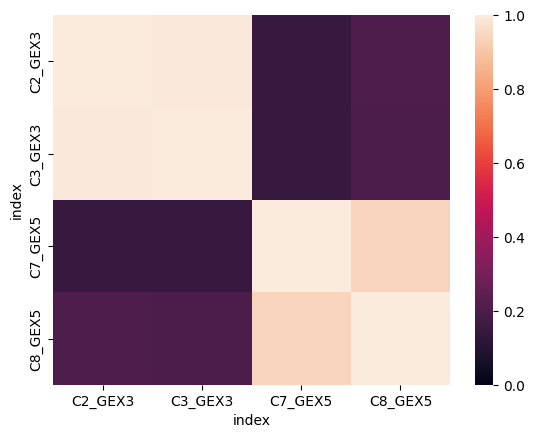

In [20]:
sample_matrix = concat_techs([df1,df2],['GEX3','GEX5'],'C')
sample_matrix.drop(columns=['C9_GEX5','C10_GEX5'], inplace=True)
sns.heatmap(sample_matrix.corr(),vmin=0)

### Compare all technologies

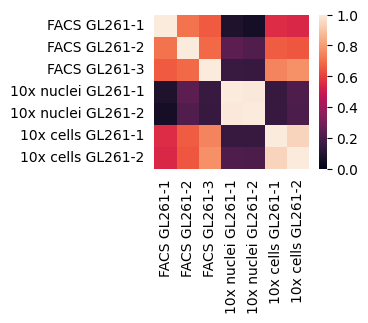

In [27]:
sample_matrix = concat_techs([df3,df1,df2],['SS2','GEX3','GEX5'],'C')
sample_matrix.drop(columns=['C9_GEX5','C10_GEX5'], inplace=True)

with rc_context({'font.size': 10.0,'figure.figsize': (2.5,2)}):

    g = sns.heatmap(sample_matrix.corr(),vmin=0)
    g.set_xlabel('')
    g.set_ylabel('')
    g.yaxis.set_ticklabels(['FACS GL261-1', 'FACS GL261-2', 'FACS GL261-3', '10x nuclei GL261-1','10x nuclei GL261-2', '10x cells GL261-1', '10x cells GL261-2'])
    g.xaxis.set_ticklabels(['FACS GL261-1', 'FACS GL261-2', 'FACS GL261-3', '10x nuclei GL261-1','10x nuclei GL261-2', '10x cells GL261-1', '10x cells GL261-2'])
    g.tick_params(left=False, bottom=False)

    plt.savefig(f'./figures/similarity_GL261.png', bbox_inches='tight', dpi=300)


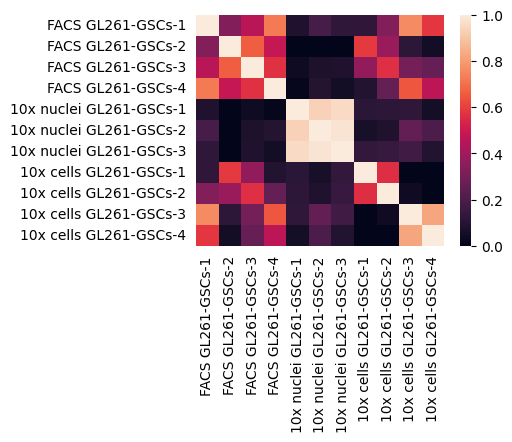

In [32]:
sample_matrix = concat_techs([df3,df1,df2],['SS2','GEX3','GEX5'],'S')
# sample_matrix.drop(columns=['S2_GEX5','S3_GEX5','S4_GEX5'], inplace=True)

with rc_context({'font.size': 10.0,'figure.figsize': (4,3)}):

    g = sns.heatmap(sample_matrix.corr(),vmin=0)
    g.set_xlabel('')
    g.set_ylabel('')
    g.yaxis.set_ticklabels(['FACS GL261-GSCs-1', 'FACS GL261-GSCs-2', 'FACS GL261-GSCs-3', 'FACS GL261-GSCs-4', '10x nuclei GL261-GSCs-1','10x nuclei GL261-GSCs-2', '10x nuclei GL261-GSCs-3', '10x cells GL261-GSCs-1', '10x cells GL261-GSCs-2','10x cells GL261-GSCs-3','10x cells GL261-GSCs-4'])
    g.xaxis.set_ticklabels(['FACS GL261-GSCs-1', 'FACS GL261-GSCs-2', 'FACS GL261-GSCs-3', 'FACS GL261-GSCs-4', '10x nuclei GL261-GSCs-1','10x nuclei GL261-GSCs-2', '10x nuclei GL261-GSCs-3', '10x cells GL261-GSCs-1', '10x cells GL261-GSCs-2','10x cells GL261-GSCs-3','10x cells GL261-GSCs-4'])
    g.tick_params(left=False, bottom=False)

    plt.savefig(f'./figures/similarity_GL261-GSCs.png', bbox_inches='tight', dpi=300)
